In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/val/2/39457_left.jpeg
/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/val/2/20882_right.jpeg
/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/val/2/7884_left._aug_18.jpeg
/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/val/2/1873_left._aug_2.jpeg
/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/val/2/26113_right.jpeg
/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/val/2/33956_left._aug_13.jpeg
/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/val/2/32216_right._aug_27.jpeg
/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/val/2/43609_left._aug_29.jpeg
/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/val/2/41076_right._aug_9.jpeg
/kaggle/input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/val/

In [2]:
import zipfile
import os
import PIL
import glob
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import keras.utils as image
from PIL import Image, ImageOps

from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle                   
from tqdm import tqdm

from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [3]:
datasets_dir = '../input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/'
os.listdir(datasets_dir)

['val', 'test', 'train']

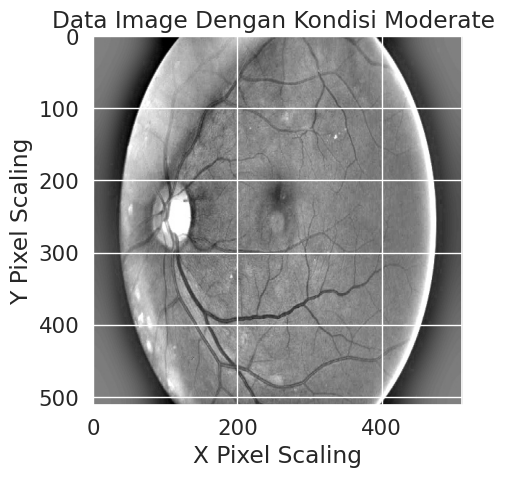

In [4]:
image = cv2.imread('../input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/train/2/1002_right.jpeg')

plt.title("Data Image Dengan Kondisi Moderate ")
plt.xlabel("X Pixel Scaling")
plt.ylabel("Y Pixel Scaling")
plt.imshow(image)
plt.show()

In [5]:
cv2.imread("../input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/train/2/1002_right.jpeg").shape

(512, 512, 3)

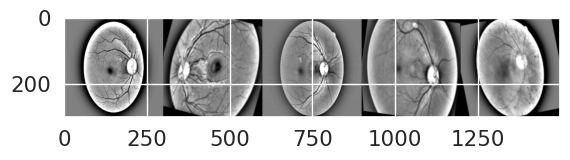

In [6]:
img0 = cv2.imread("../input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/train/0/10007_right.jpeg")
img1 = cv2.imread("../input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/train/1/10085_right._aug_1._aug_15.jpeg")
img2 = cv2.imread("../input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/train/2/10109_right.jpeg")
img3 = cv2.imread("../input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/train/3/10125_right._aug_2._aug_16.jpeg")
img4 = cv2.imread("../input/diabetic-retinopathy-balanced/content/Diabetic_Balanced_Data/train/4/10017_right._aug_25.jpeg")

Hori = np.concatenate((img0, img1, img2, img3, img4), axis=1)
imS = cv2.resize(Hori, (1500, 300))
plt.imshow(imS)
plt.show()

In [7]:
train_dir = os.path.join(datasets_dir,'train/')
val_dir = os.path.join(datasets_dir,'val/')
test_dir = os.path.join(datasets_dir,'test/')

In [8]:
def GetDatasetSize(path):
    num_of_image = {}
    for folder in os.listdir(path):
        # Counting the Number of Files in the Folder
        num_of_image[folder] = len(os.listdir(os.path.join(path, folder)));
    return num_of_image;

In [9]:
train_set  = GetDatasetSize(train_dir)
val_set = GetDatasetSize(val_dir)
test_set = GetDatasetSize(test_dir)

print(train_set,"\n\n",val_set,"\n\n",test_set)

{'2': 7000, '0': 7000, '3': 7000, '1': 6792, '4': 7000} 

 {'2': 2000, '0': 2000, '3': 2000, '1': 1940, '4': 2000} 

 {'2': 1000, '0': 1000, '3': 1000, '1': 971, '4': 1000}


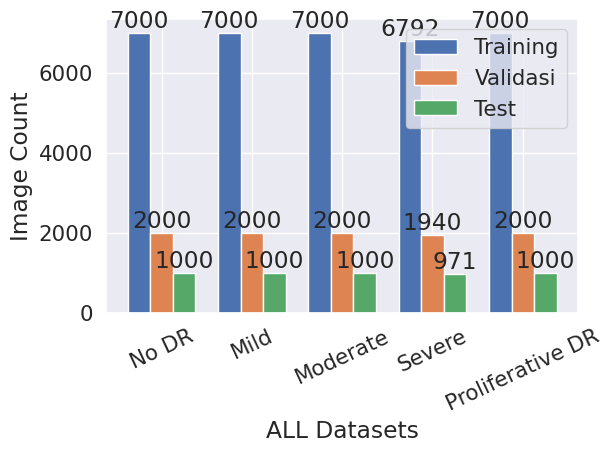

In [10]:
labels = ['No DR','Mild','Moderate','Severe','Proliferative DR']

train_list = list(train_set.values())
val_list = list(val_set.values())
test_list = list(test_set.values())

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots()

rects1 = ax.bar(x - width, train_list, width, label='Training')
rects2 = ax.bar(x, val_list, width, label='Validasi')
rects3 = ax.bar(x + width, test_list, width, label='Test')



ax.set_ylabel("Image Count")
ax.set_xlabel("ALL Datasets")
ax.set_xticks(x, labels)
plt.xticks(rotation=25)
ax.legend()

ax.bar_label(rects1)
ax.bar_label(rects2)
ax.bar_label(rects3)

fig.tight_layout()

plt.show()

In [11]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    horizontal_flip = True,
    shear_range = 0.3,
    fill_mode = 'nearest',
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    dtype=None,
    zoom_range = 0.1
)

val_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    horizontal_flip = True,
    shear_range = 0.3,
    fill_mode = 'nearest',
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    dtype=None,
    zoom_range = 0.1
)

test_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    horizontal_flip = True,
    shear_range = 0.3,
    fill_mode = 'nearest',
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    dtype=None,
    zoom_range = 0.1
)

In [12]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 10,
    class_mode = 'categorical'
)

val_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 10,
    class_mode = 'categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (150, 150),
    batch_size = 10,
    class_mode = 'categorical'
)

Found 34792 images belonging to 5 classes.
Found 34792 images belonging to 5 classes.
Found 4971 images belonging to 5 classes.


In [13]:
train_generator.class_indices

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}

In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu',input_shape=(150,150,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
  
    tf.keras.layers.Conv2D(256, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(512, kernel_size=3, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 148, 148, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 72, 72, 64)       256       
 hNormalization)                                                 
                                                        

In [16]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
#     f1_score,
]


In [17]:
# from keras.optimizers import Adam
# model.compile(
#     loss = 'categorical_crossentropy',
#     optimizer = Adam(lr=0.0005, beta_1=0.9, beta_2=0.99),
#     metrics=['accuracy']
# )

model.compile(
    optimizer='Adam', 
    loss="categorical_crossentropy",
     metrics=METRICS
)

In [18]:
history=model.fit(
    train_generator,
    steps_per_epoch=9,
    epochs=10,
    validation_data=val_generator,
    validation_steps=1,
    verbose=1,
)

Epoch 1/10
9/9 [==============================] - 16s 1s/step - loss: 46.2642 - accuracy: 0.6911 - precision: 0.2184 - recall: 0.2111 - auc: 0.5312 - val_loss: 13.9727 - val_accuracy: 0.7200 - val_precision: 0.3000 - val_recall: 0.3000 - val_auc: 0.5625
Epoch 2/10
9/9 [==============================] - 13s 1s/step - loss: 41.3617 - accuracy: 0.7200 - precision: 0.3000 - recall: 0.3000 - auc: 0.5639 - val_loss: 34.5142 - val_accuracy: 0.6400 - val_precision: 0.1000 - val_recall: 0.1000 - val_auc: 0.4275
Epoch 3/10
9/9 [==============================] - 12s 1s/step - loss: 42.5895 - accuracy: 0.6978 - precision: 0.2444 - recall: 0.2444 - auc: 0.5233 - val_loss: 15.7465 - val_accuracy: 0.7000 - val_precision: 0.2222 - val_recall: 0.2000 - val_auc: 0.5063
Epoch 4/10
9/9 [==============================] - 12s 1s/step - loss: 43.1385 - accuracy: 0.7067 - precision: 0.2667 - recall: 0.2667 - auc: 0.5393 - val_loss: 10.3705 - val_accuracy: 0.7600 - val_precision: 0.4000 - val_recall: 0.4000 - 

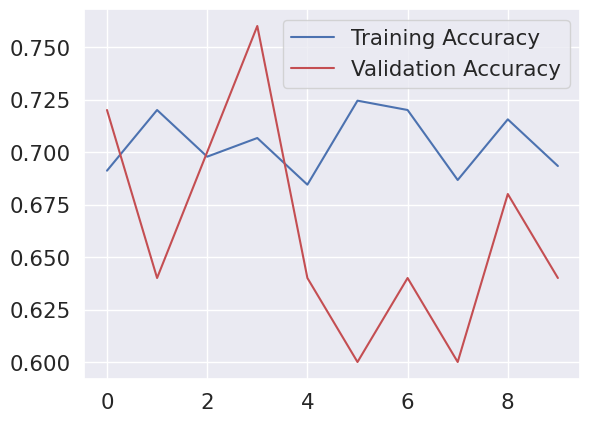

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.legend(loc='best')
plt.show()

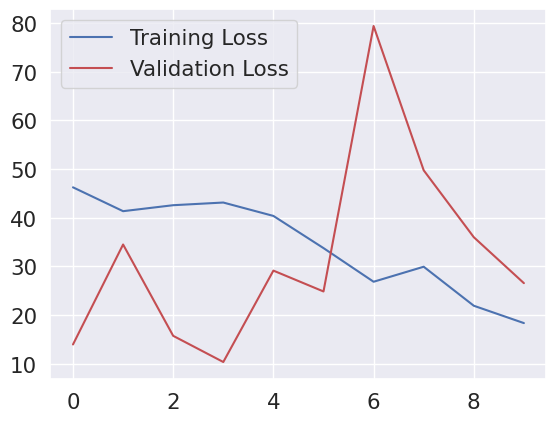

In [20]:
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.legend(loc = 'best')
plt.show()

In [21]:
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
predict_x = model.predict(test_generator)

498/498 [==============================] - 139s 279ms/step


In [22]:
model_save = ModelCheckpoint('./Model5.h5',
                             save_best_only = True,
                             save_weights_only = False,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)

In [23]:
from sklearn.metrics import classification_report,confusion_matrix

In [24]:
# predictions = np.argmax(predict_x, axis = 1)
# predictions_ = predictions.reshape(1,-1)[0]
# print(classification_report(
#     test_generator.classes, 
#     predictions,
#     target_names=['No DR (Class 0)',
#                   'Mild (Class 1)',
#                   'Moderate (Class 2)', 
#                   'Severe (Class 3)',
#                   'Proliferative DR (Class 4)'
# ]))

In [25]:
train_score = model.evaluate(train_generator, verbose= 1)
valid_score = model.evaluate(val_generator, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])

3480/3480 [==============================] - 946s 272ms/step - loss: 23.5309 - accuracy: 0.6805 - precision: 0.2012 - recall: 0.2012 - auc: 0.5007
Train Loss:  23.537273406982422
Train Accuracy:  0.6804782748222351
--------------------
Validation Loss:  23.53093719482422
Validation Accuracy:  0.6804782748222351
